In [222]:
#data prep
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from pandas import Series
from matplotlib.patches import Circle
import seaborn as sns
from datetime import datetime,timedelta
import numpy  as np
import scipy.stats as stats

zscore_limit = 3
def dataPrep():
    # get data
    dfCaudal = pd.read_excel(r'caudal.xlsx')
    dfCaudal = pd.DataFrame(dfCaudal, columns=['Tempo', 'Caudal'])
    
    # data setup
    dfCaudal['Tempo'] = pd.to_datetime(dfCaudal['Tempo'])
    dfCaudal['Caudal'] = pd.to_numeric(dfCaudal['Caudal'], errors='coerce')
    dfCaudal.set_index('Tempo', inplace=True)
    dfCaudal.dropna(inplace=True)
    

    dfCaudal['zscore'] = stats.zscore(dfCaudal.Caudal)
    dfCaudal['mean12'] = dfCaudal['Caudal'].rolling(12).mean()
    dfCaudal.loc[dfCaudal['zscore'] > zscore_limit, 'Caudal'] = dfCaudal['mean12']
    
    # split by invalid points - points where time diff is too big > 7
    dfCaudal['timediff'] = dfCaudal.index.to_series().diff()
    dfCaudal.dropna(inplace=True)
    dataSetCuts = dfCaudal[dfCaudal['timediff'] > timedelta(hours=7)]
    dfCaudal =  dfCaudal[dfCaudal['Caudal'] != 0]
    dataSetCuts = pd.concat([dfCaudal.head(1), dataSetCuts, dfCaudal.tail(1)])
    dataSetLists = []
    prev_row = None
    for index, row in  dataSetCuts.iterrows():
         if prev_row is None:
            prev_row = row
         else:
            dataSetLists.append(dfCaudal.loc[prev_row.name:row.name, :].copy())
            prev_row = row
    
    
    # get first and second derivative 
    for index, df in enumerate(dataSetLists):
        df['diff'] = df['Caudal'].diff()
        df['diff2'] = df['diff'].diff()
        df.dropna(inplace=True)
    return dataSetLists
dataSetList = dataPrep()

C:\Users\Francisco\AppData\Local\Temp\ipykernel_10028\769442663.py:51: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if row.name in modified_dates:


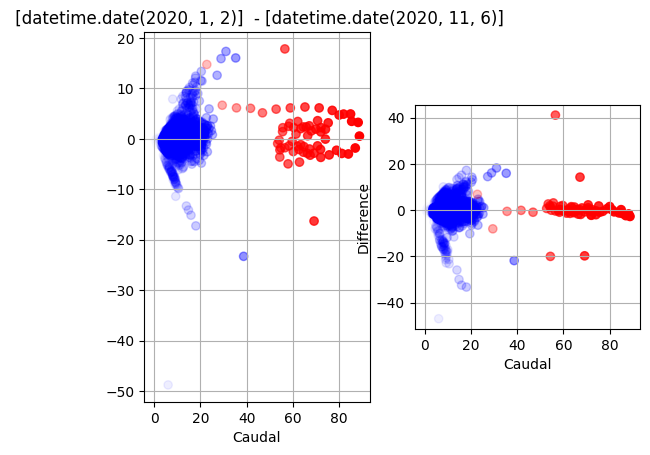

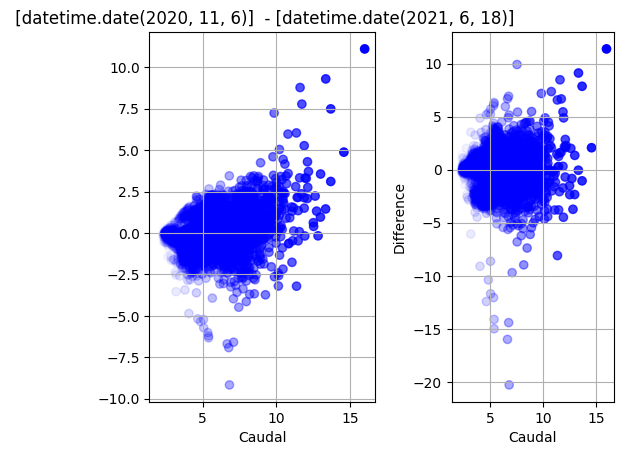

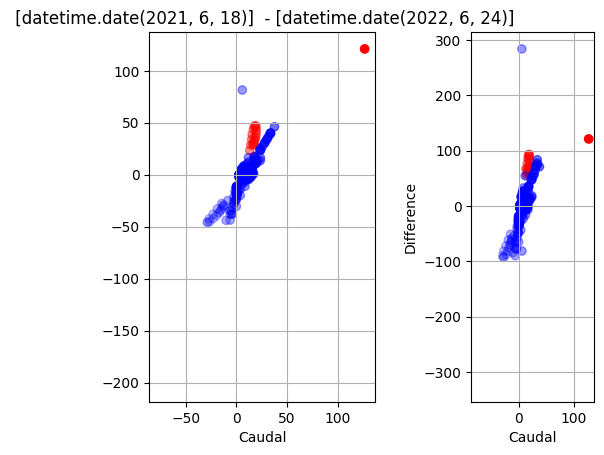

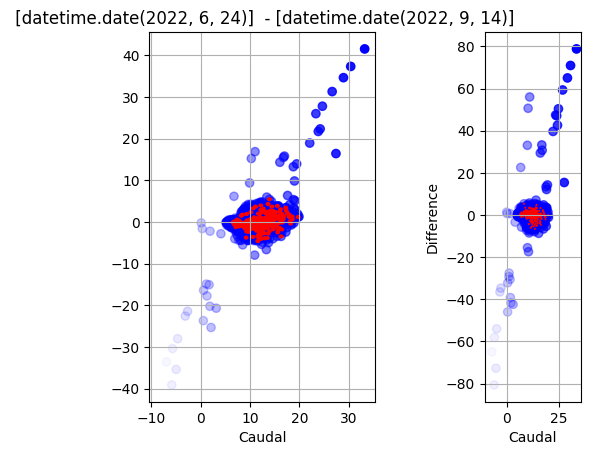

In [239]:
#get revelant dates 5 days before the exec
format_string = '%Y-%m-%d'
intervencaoDays = [
                   #'2022-05-26', '2022-05-20', '2022-05-19','2022-05-12',
                   '2022-07-01', '2022-07-08', '2022-08-04', '2022-08-29', '2022-10-07']
date_times = [datetime.strptime(date_string, format_string).date() for date_string in intervencaoDays]
modified_dates = []
for date in date_times:
    # subtract n days from the current date
    days = 5
    modified_date = date - timedelta(days=days)
    for i in range(days - 2):
        modified_dates.append(modified_date + timedelta(days=i+1))
#print(modified_dates)



for index, df in enumerate(dataSetList):
    colors = ['red' if df['zscore'][i] > zscore_limit else 'blue' for i in range(len(df))]
    min_value = df['Caudal'].min()
    max_value = df['Caudal'].max()
    df['Caudal_normalized'] = (df['Caudal'] - min_value) / (max_value - min_value)
    alpha_values = df['Caudal_normalized']
    
    dateStart = df.head(1).index.date
    dateEnd = df.tail(1).index.date
    title = f' {dateStart}  - {dateEnd}'
    
    fig, ax = plt.subplots(1, 2)
    # Plot the data in the first subplot
    ax[0].scatter(df['Caudal'], df['diff'], c = colors, alpha=alpha_values)
    ax[0].set_title(title)
    ax[0].set_xlabel('Caudal')
    # Add a grid to the first subplot
    ax[0].grid()
    
    #for i, txt in enumerate(df.index):
    #    if df['zscore'][i] > zscore_limit:
    #        ax[0].annotate(txt, (df['Caudal'][i], df['diff'][i]))
    
    # Plot the data in the second subplot
    ax[1].scatter(df['Caudal'], df['diff2'], c = colors,  alpha=alpha_values)

    ax[1].set_xlabel('Caudal')
    ax[1].set_ylabel('Difference')
    ax[1].set_aspect('equal')
    ax[1].grid()
    
    
    for i, row in df.iterrows():
        if row.name in modified_dates:
            #print(row)
            circ = Circle((row['Caudal'], row['diff']), radius=0.5, facecolor='red', alpha=1)
            ax[0].add_patch(circ)
                
            circ2 = Circle((row['Caudal'], row['diff2']), radius=0.5, facecolor='red', alpha=1)
            ax[1].add_patch(circ2)
            ax[1].set_aspect('equal')
        
       
    
plt.show()    

In [ ]:
dataSetList

In [111]:
dfCaudal['diff'] = dfCaudal['Caudal'].diff()
dfCaudal['diff2'] = dfCaudal['diff'].diff()
dfCaudal.dropna(inplace=True)

In [112]:
dfCaudal.head()

,Caudal,zscore,mean12,diff,diff2
Tempo,,,,,
2020-01-02 12:26:52,6.70,-0.074952,4.758333,-0.29,-1.18
2020-01-02 13:26:52,7.00,-0.046434,5.041667,0.30,0.59
2020-01-02 14:26:52,6.60,-0.084458,5.316667,-0.40,-0.70
2020-01-02 15:26:57,5.79,-0.161456,5.524167,-0.81,-0.41
2020-01-02 16:26:57,5.50,-0.189023,5.640833,-0.29,0.52


In [113]:
#plt.plot(dfCaudal.Caudal, dfCaudal.diff)

dfCaudal['diff'].count()

24047

In [114]:
dfCaudal['Caudal'].count()

24047

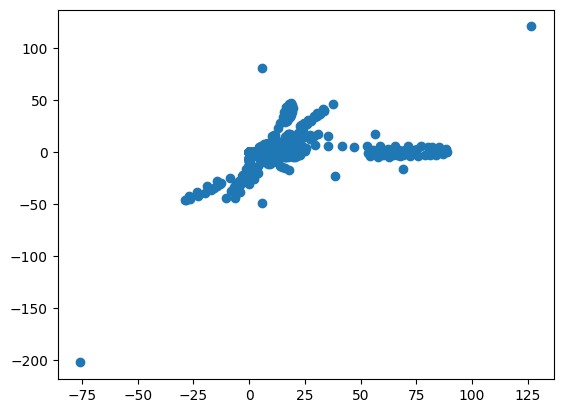

In [115]:
#plt.plot(dfCaudal['diff'], dfCaudal['Caudal'])
plt.scatter(dfCaudal['Caudal'], dfCaudal['diff'])


In [116]:
from sklearn.cluster import KMeans

In [149]:
def normalizeData(df, col_x, col_y):
    # set the x and y variables
    col_x = 'Caudal'
    col_y = 'diff'

    x_mean = df[col_x].mean()
    x_stdev = df[col_x].std()

    y_mean = df[col_y].mean()
    y_stdev = df[col_y].std()

    print(x_mean, x_stdev)
    print(y_mean, y_stdev)

    # calculate the normalised values on x and y
    x_min = min(df[col_x])
    x_max = max(df[col_x])

    norm_x = ((df[col_x] - x_min)/(x_max - x_min))
    df['norm_x'] = norm_x

    y_min = min(df[col_y])
    y_max = max(df[col_y])

    norm_y = ((df[col_y] - y_min)/(y_max - y_min))
    df['norm_y'] = norm_y
    
normalizeData(dfCaudal, col_x, col_y)


x_y = np.column_stack((dfCaudal['norm_x'], dfCaudal['norm_y']))

km_res = KMeans(n_clusters=2).fit(x_y)
clusters = km_res.cluster_centers_
clusters

figure(num=None, figsize=(10, 10), dpi=100, facecolor='w', edgecolor='k')

plt.xlabel(col_x)
plt.ylabel(col_y)

plt.scatter(dfCaudal.norm_x, dfCaudal.norm_y, alpha = 0.25, s = 100, color='red')
plt.title("Kmeans Diff vs Caudal", fontsize=18)
plt.scatter(clusters[:,0], clusters[:,1], s = 100000, alpha=0.30)
#[plt.text(x=dfCaudal.norm_x, y=dfCaudal.norm_y, s=row['Caudal']) for k,row in dfCaudal.iterrows() if row.Caudal > 30]


7.40027373476941 4.680418929893152
-0.00029068075019752484 2.9924347447944144


C:\Users\Francisco\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


[Text(Tempo
 2020-01-02 12:26:52    0.407529
 2020-01-02 13:26:52    0.409012
 2020-01-02 14:26:52    0.407034
 2020-01-02 15:26:57    0.403030
 2020-01-02 16:26:57    0.401597
                          ...   
 2022-10-18 19:37:59    0.374408
 2022-10-18 20:37:57    0.374408
 2022-10-18 21:37:57    0.374408
 2022-10-18 22:37:57    0.374408
 2022-10-18 23:37:57    0.374408
 Name: norm_x, Length: 24047, dtype: float64, Tempo
 2020-01-02 12:26:52    0.624747
 2020-01-02 13:26:52    0.626572
 2020-01-02 14:26:52    0.624407
 2020-01-02 15:26:57    0.623139
 2020-01-02 16:26:57    0.624747
                          ...   
 2022-10-18 19:37:59    0.625644
 2022-10-18 20:37:57    0.625644
 2022-10-18 21:37:57    0.625644
 2022-10-18 22:37:57    0.625644
 2022-10-18 23:37:57    0.625644
 Name: norm_y, Length: 24047, dtype: float64, '31.05'),
 Text(Tempo
 2020-01-02 12:26:52    0.407529
 2020-01-02 13:26:52    0.409012
 2020-01-02 14:26:52    0.407034
 2020-01-02 15:26:57    0.403030
 2020-01-0

Error in callback <function _draw_all_if_interactive at 0x000001D138996B90> (for post_execute):


TypeError: cannot convert the series to <class 'float'>

TypeError: cannot convert the series to <class 'float'>

<Figure size 1000x1000 with 1 Axes>

[Text(Tempo
 2020-01-02 12:26:52    0.407529
 2020-01-02 13:26:52    0.409012
 2020-01-02 14:26:52    0.407034
 2020-01-02 15:26:57    0.403030
 2020-01-02 16:26:57    0.401597
                          ...   
 2022-10-18 19:37:59    0.374408
 2022-10-18 20:37:57    0.374408
 2022-10-18 21:37:57    0.374408
 2022-10-18 22:37:57    0.374408
 2022-10-18 23:37:57    0.374408
 Name: norm_x, Length: 24047, dtype: float64, Tempo
 2020-01-02 12:26:52    0.624747
 2020-01-02 13:26:52    0.626572
 2020-01-02 14:26:52    0.624407
 2020-01-02 15:26:57    0.623139
 2020-01-02 16:26:57    0.624747
                          ...   
 2022-10-18 19:37:59    0.625644
 2022-10-18 20:37:57    0.625644
 2022-10-18 21:37:57    0.625644
 2022-10-18 22:37:57    0.625644
 2022-10-18 23:37:57    0.625644
 Name: norm_y, Length: 24047, dtype: float64, '31.05'),
 Text(Tempo
 2020-01-02 12:26:52    0.407529
 2020-01-02 13:26:52    0.409012
 2020-01-02 14:26:52    0.407034
 2020-01-02 15:26:57    0.403030
 2020-01-0

Error in callback <function _draw_all_if_interactive at 0x000001D138996B90> (for post_execute):


TypeError: cannot convert the series to <class 'float'>

TypeError: cannot convert the series to <class 'float'>

<Figure size 640x480 with 1 Axes>

In [130]:
clusters

array([[0.40296559, 0.6250041 ],
       [0.70866289, 0.63354498],
       [0.3772105 , 0.62141117],
       [0.44990688, 0.63284148],
       [0.4189664 , 0.62601382]])

In [20]:
def prepDataSet(caudal):
    #cau = caudal.resample('3H').max()
    caudal['diff'] = caudal['Caudal'].diff()
    
    
    
    '''diff2 = diff.diff()
    diff3 = diff2.diff()
    diff4 = diff3.diff()
    diff5 = diff4.diff()
    cau['diff2'] = diff
    cau['diff3'] = diff2.diff()
    cau['diff4'] = diff3.diff()
    cau['diff5'] = diff4.diff()
    cau['diff6'] = diff5.diff()'''
    
    #cau['Weekday'] = cau.index.dayofweek
    #cau['month'] = cau.index.month
    # no data = '2022-06-13','2022-06-20', '2022-06-27',
    values = ['2022-05-26', '2022-05-20', '2022-05-19','2022-05-12', '2022-07-01', '2022-07-08', '2022-08-04', '2022-08-29', '2022-10-07']
    #np.where((abs(cau['diff6']) > 2), 3,0)
    caudal['Y'] = np.where(caudal.index.isin(values), 1, 0)
    #cau['Max'] = dfCaudal.resample('12H').max()
    #cau['Min'] = dfCaudal.resample('12H').min()
    #cau['Std'] = dfCaudal.resample('12H').std()
    #cau = cau.loc[cau.index < '2022-6-09']
    caudal.dropna(inplace=True)
    return caudal


#data['diff6'].loc[cau.index > '2022-6-25'].plot()
     

In [27]:
data = prepDataSet(dfCaudal)
data.head()

,Caudal,diff,Y
Tempo,,,
2020-01-02 05:26:54,3.30,0.00,0
2020-01-02 06:26:54,3.50,0.20,0
2020-01-02 07:26:49,4.31,0.21,0
2020-01-02 08:26:49,5.80,2.50,0
2020-01-02 09:26:49,6.10,2.60,0


In [26]:
data[data['Y']==1].count()

Caudal    0
diff      0
Y         0
dtype: int64

In [381]:
data.count()

Caudal     860
diff2      860
diff3      860
diff4      860
diff5      860
diff6      860
Weekday    860
month      860
Y          860
Max        860
Min        860
Std        860
dtype: int64

In [364]:
data.loc['2022-07-01']

,Caudal,diff2,diff3,diff4,diff5,diff6,Weekday,month,Y,Max,Min,Std
Tempo,,,,,,,,,,,,
2022-07-01 00:00:00,13.955833,-2.130000,-10.389167,-21.055000,-42.550000,-85.205833,4,7,1,16.64,11.79,1.426091
2022-07-01 12:00:00,14.495000,0.539167,7.777500,18.166667,39.221667,81.771667,4,7,0,18.68,11.31,1.931916


In [14]:
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics


In [18]:

def trainTestPredict(data):
    Y = data['Y']
    Y = Y.astype('int')
    X = data.drop(labels=['Y'], axis=1)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=30)

    model = RandomForestClassifier(n_estimators= 1000, random_state=30)

    model.fit(X_train, Y_train)

    prediction_test = model.predict(X_test)
    print(prediction_test[prediction_test == 1])
    #print(prediction_test)    
    print("Accuracy = ", metrics.accuracy_score(Y_test, prediction_test))

    feature_list = list(X.columns)
    feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
    print(feature_imp)
    #print(X_test)
    #print(Y_test[Y_test == 1] )
    
    #print(Y_train)
    #print(Y_train[Y_train == 1] )
    
trainTestPredict(data)

[]
Accuracy =  1.0
Caudal    0.0
diff      0.0
dtype: float64
